# 10-5-3 Fig 6
This notebook generates the results in section 4.2 of the paper.

In [1]:
%load_ext autoreload
%autoreload 1
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
dtype = torch.float
device = torch.device("cpu")
#device = torch.device("cuda:0") # Uncomment this to run on GPU
%aimport NeuralNetwork
%aimport Layer
import importlib
import time
from IPython.display import display
from ipywidgets import FloatProgress
from copy import deepcopy

In [2]:
def ClassPlot(x, labels=[], idx=(1,2)):
    # FeedForward
    #yc = Network.OneHot(y)
    if len(labels)>0:
        colour_options = ['y', 'r', 'g', 'b', 'k']
        cidx = np.argmax(labels, axis=1)
        colours = [colour_options[k] for k in cidx]
        plt.scatter(x[:,idx[0]], x[:,idx[1]], color=colours, marker='.')
    else:
        plt.scatter(x[:,idx[0]], x[:,idx[1]], marker='.')
    plt.axis('equal');

## Create a simple dataset

In [3]:
# This creates a dataset

n_classes = 3
hidden_dim = 5
sensory_dim = 10

seed = 2951
torch.manual_seed(seed)
np.random.seed(seed)
B = np.eye(n_classes)
X = 3.*(np.random.rand(sensory_dim, n_classes) - 0.5)
A = X.T
print('Bottom vectors')
print(B)
print('Top vectors')
print(A)
#print('System matrix:\n'+str(M))

Bottom vectors
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Top vectors
[[ 0.14755352  0.46565417 -0.78856331  1.41517622 -0.16337354  0.09342559
   0.85847596 -0.98865854  0.59412645  1.25364742]
 [-0.53716098 -0.57700345  0.14883325  1.40056145 -1.42285063  0.71380726
   0.40828328  1.30226861  1.30820269 -0.96784184]
 [ 0.65372374 -0.51046803  0.82650348  1.45073099 -0.80659897  1.49439375
  -1.20738721 -0.58307763 -0.88159913  0.53325945]]


In [4]:
# Use A and B to make a dataset
def MakeDataset(A, B, n=300, noise=0.2):
    n_classes, top_dim = np.shape(A)
    bottom_dim = n_classes

    training_samples = n
    #noise = 0.2
    training_input = []
    training_output = []
    for n in range(training_samples):
        r = np.random.randint(n_classes)
        training_input.append(B[r])
        training_output.append(A[r]+noise*np.random.normal(size=np.shape(A[r])))

    training_input = torch.tensor(training_input).float().to(device)
    training_output = torch.tensor(training_output).float().to(device)
    train = [training_input, training_output]
    return train

In [5]:
train = MakeDataset(A, B, noise=0.2)

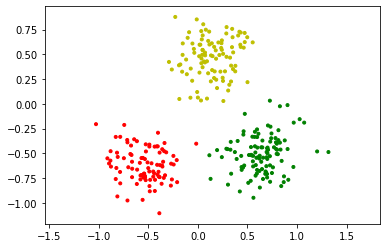

In [6]:
idx = (0,1)
ClassPlot(train[1].cpu(), labels=train[0].cpu(), idx=idx)

## Create Some Networks

In [7]:
# Option 1
net = NeuralNetwork.NeuralNetwork()
net.AddLayer(Layer.InputPELayer(n=n_classes))
net.AddLayer(Layer.PELayer(n=hidden_dim))
net.AddLayer(Layer.TopPELayer(n=sensory_dim))

sym = True
af = 'identity'
net.Connect(0, 1, act=af, symmetric=sym)
net.Connect(1, 2, act=af, symmetric=sym)

identity
identity


In [38]:
# Option 2
net = NeuralNetwork.NeuralNetwork()
net.AddLayer(Layer.InputPELayer(n=n_classes))
net.AddLayer(Layer.PELayer(n=hidden_dim))
#net.AddLayer(Layer.PELayer(n=hidden_dim+2))
net.AddLayer(Layer.TopPELayer(n=sensory_dim))

sym = True
af = 'tanh'
net.Connect(0, 1, act=af, symmetric=sym)
net.Connect(1, 2, act=af, symmetric=sym)
#net.Connect(2, 3, act=af, symmetric=sym)

tanh
tanh


In [39]:
net.SetTau(0.05)
net.learning_tau = 0.1
net.learn_biases = False

## Training

In [40]:
T = 4.
epochs = 5
bs = 50

In [41]:
# No nuthin' (just the basic PC network)
net_nn = deepcopy(net)
netx = net_nn
netx.SetWeightDecay(0.0)
netx.SetvDecay(0.0)
netx.Learn(train[0], train[1], T=T, dt=0.001, epochs=epochs, batch_size=bs, learning_delay=0.)

FloatProgress(value=0.0, max=1500.0)

In [42]:
# Just decay
net0 = deepcopy(net)
netx = net0
netx.SetWeightDecay(0.05)
netx.SetvDecay(0.0)
netx.Learn(train[0], train[1], T=T, dt=0.001, epochs=epochs, batch_size=bs, learning_delay=0.)

FloatProgress(value=0.0, max=1500.0)

## Save or Load

### Save it if you want

In [10]:
net0.Save('no_decay.npy')

### Or load one

In [ ]:
net10 = NeuralNetwork.NeuralNetwork()
net10.Load('no_decay.npy')

In [ ]:
net10.layers[0].v

In [ ]:
net0 = NeuralNetwork.NeuralNetwork()
net0.Load('no_decay.npy')

## Test classification

In [43]:
# In the backwards nomenclature, "Generate" is the feedforward direction.
netx = net_nn
#netx.Reset()
netx.Allocate(train[1])
netx.Reset(random=1.)
mu0 = netx.Generate(5., train[1], dt=0.001)
print(np.array(mu0[:6]))

[[-0.01556899 -0.01876638  0.99891573]
 [ 0.02018311  0.998684   -0.0225768 ]
 [ 0.00740381  0.9961307  -0.0202294 ]
 [ 0.01783333  1.0205393  -0.04264489]
 [ 1.0333341   0.00252856 -0.03128751]
 [-0.0111711   1.0313631  -0.00520622]]


In [44]:
# In the backwards nomenclature, "Generate" is the feedforward direction.
netx = net0
netx.Allocate(train[1])
netx.Reset(random=1.)
mu0 = netx.Generate(5., train[1], dt=0.001)
print(np.array(mu0[:6]))

[[-0.01005489 -0.02202428  0.8730549 ]
 [ 0.02131616  0.90324163 -0.01691713]
 [ 0.03844247  0.8690823  -0.05304053]
 [ 0.04062211  0.9189935  -0.06309689]
 [ 0.88050264 -0.00742146 -0.03660133]
 [ 0.00272657  0.92843366  0.00531783]]


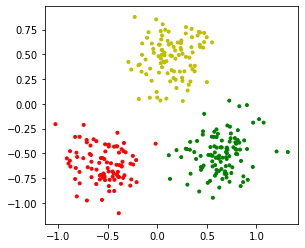

In [45]:
fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1); ClassPlot(train[1], labels=mu0, idx=idx)

## Generative abilities

In [46]:
print_it = True

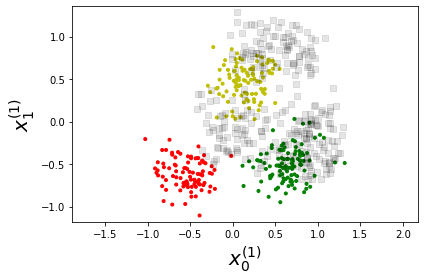

In [60]:
netx = net_nn
netx.Allocate(train[0])
netx.Reset(random=1.)
netx.SetvDecay(0.0)
#v0 = netx.Predict(10., torch.eye(3))
v0 = netx.Predict(10., train[0])
ClassPlot(train[1], labels=train[0], idx=idx)
plt.plot(np.array(v0[:,idx[0]]), np.array(v0[:,idx[1]]), 's', color=[0,0,0,0.1]);
a = plt.axis('equal');
plt.xlabel(r'$x^{(1)}_0$', fontsize=20);
plt.ylabel(r'$x^{(1)}_1$', fontsize=20);
if print_it:
    plt.tight_layout()
    plt.savefig('10-5-3'+af+'_no_decay.pdf')

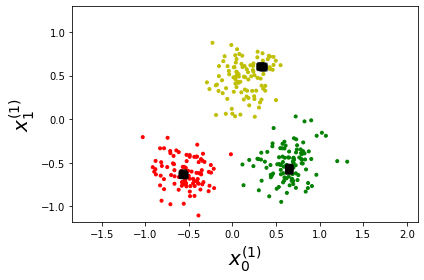

In [55]:
netx = net0
netx.Allocate(train[0])
netx.Reset(random=1.)
netx.SetvDecay(0.01)
v0 = netx.Predict(10., train[0])
ClassPlot(train[1], labels=train[0], idx=idx)
plt.plot(np.array(v0[:,idx[0]]), np.array(v0[:,idx[1]]), 's', color=[0,0,0,0.1]);
plt.axis(a);
plt.xlabel(r'$x^{(1)}_0$', fontsize=20);
plt.ylabel(r'$x^{(1)}_1$', fontsize=20);
if print_it:
    plt.tight_layout()
    plt.savefig('10-5-3'+af+'_decay_proc.pdf')